In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import accuracy_score

import pickle
import numpy
from numpy import vstack
import math

from numpy.random import default_rng
%matplotlib inline 
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

rng = default_rng()
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla K80


In [2]:
dir_path = "/content/drive/My Drive/Capstone"
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata = unpickle(dir_path + '/cifar-100-python/meta')
trainDataDict = unpickle(dir_path + '/cifar-100-python/train')
testDataDict = unpickle(dir_path + '/cifar-100-python/test')

In [3]:
print(len(metadata[b'fine_label_names']))
print(len(metadata[b'coarse_label_names']))
print(len(trainDataDict))
print(len(testDataDict))
print(trainDataDict.keys())
#len(trainData[b'fine_labels'])
len(trainDataDict[b'fine_labels'])

100
20
5
5
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


50000

In [4]:
def partitionClients(numClients, dataDict):
    classDist = [0.1 for i in range(numClients)]
    # trainDataByClient is a list of lists. Each inner list contains all the indexes of images that belong to that client
    trainDataByClientIdxs = []
    # Initialize list of dicts
    for i in range(numClients):
        trainDataByClientIdxs.append([])

    for labelClass in range(100):
        clientDist = rng.dirichlet(classDist)
            
        dataIdx = 0
        for client in range(numClients):
            totalImgs = math.floor(clientDist[client]*(len(dataDict[b'fine_labels'])/100))
            if (totalImgs == 0):
                continue
            imgsSaved = 0

            while (dataIdx < len(dataDict[b'fine_labels'])):
                # Find images with label labelClass
                if (dataDict[b'fine_labels'][dataIdx] == labelClass):
                    trainDataByClientIdxs[client].append(dataIdx)
                    imgsSaved += 1
                dataIdx += 1
                if (imgsSaved == totalImgs):
                    break

            if (imgsSaved != totalImgs):
                print("class: ", labelClass, "ran out of images")
                
    return trainDataByClientIdxs


In [5]:
trainDataIdx = partitionClients(20, trainDataDict)
testDataIdx = partitionClients(20, testDataDict)

b'dinosaur'


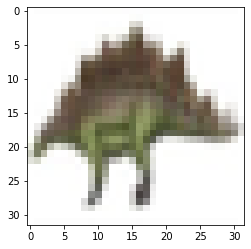

In [6]:
img = trainDataDict[b'data'][1].reshape(3,32,32)
print(metadata[b'fine_label_names'][trainDataDict[b'fine_labels'][1]])
img = numpy.moveaxis(img, 0, 2)
plt.imshow(img, interpolation='nearest')

In [7]:
class FEDCIFAR100Dataset(Dataset):
  def __init__(self, dataDict, clientIdxArr):
    self.data = dataDict
    self.idxArr = clientIdxArr
    self.len = len(self.idxArr)

  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    dataIdx = self.idxArr[idx]
    image = self.data[b'data'][dataIdx]
    img_tensor = torch.from_numpy(image.reshape(3,32,32)).float()
    label_id = torch.tensor(self.data[b'fine_labels'][dataIdx])
    return img_tensor.to(device), label_id.to(device)

In [8]:
trainData = FEDCIFAR100Dataset(trainDataDict, trainDataIdx[1])
testData = FEDCIFAR100Dataset(testDataDict, testDataIdx[1])
trainLoader = DataLoader(trainData, batch_size=64)
testLoader = DataLoader(testData, batch_size=1024)

In [ ]:
allTrainData = [i for i in range(50000)]
allTestData = [i for i in range(10000)]
allTrainData = FEDCIFAR100Dataset(trainDataDict, allTrainData)
allTestData = FEDCIFAR100Dataset(testDataDict, allTestData)
allTrainLoader = DataLoader(allTrainData, batch_size=64)
allTestLoader = DataLoader(allTestData, batch_size=1024)

In [15]:
def train_model(trainLoader, testLoader, model, epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    # enumerate epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(trainLoader):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            outputs = model(inputs)
            # calculate loss
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        evaluate_model(testLoader, model, criterion)
        
# evaluate the model
def evaluate_model(testLoader, model, criterion):
    with torch.no_grad():
      model.eval()
      totalPreds = 0
      correctPreds = 0
      for i, (inputs, targets) in enumerate(testLoader):
          # evaluate the model on the test set
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          _,predictions = torch.max(outputs, dim=1)
          correctPreds += torch.sum(predictions==targets).item()
          totalPreds += targets.size(0)

      # calculate accuracy
      acc = 100 * correctPreds/totalPreds
      print(f'Test accuracy: {(100*correctPreds/totalPreds):.2f}%\n')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
          

model = models.resnet50(pretrained=True)
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, 100)
model = model.to(device)
train_model(trainLoader, testLoader, model, 50)

Epoch 0
Test accuracy: 0.30%

Epoch 1
Test accuracy: 0.00%

Epoch 2
Test accuracy: 0.00%

Epoch 3
Test accuracy: 0.00%

Epoch 4
Test accuracy: 5.17%

Epoch 5
Test accuracy: 0.00%

Epoch 6
Test accuracy: 0.00%

Epoch 7
Test accuracy: 0.00%

Epoch 8
Test accuracy: 0.00%

Epoch 9
Test accuracy: 0.00%

Epoch 10
Test accuracy: 0.00%

Epoch 11
Test accuracy: 5.17%

Epoch 12
Test accuracy: 5.17%

Epoch 13
Test accuracy: 0.30%

Epoch 14
Test accuracy: 1.52%

Epoch 15
Test accuracy: 1.52%

Epoch 16
Test accuracy: 1.52%

Epoch 17
Test accuracy: 1.52%

Epoch 18
Test accuracy: 1.52%

Epoch 19
Test accuracy: 1.52%

Epoch 20
Test accuracy: 1.52%

Epoch 21
Test accuracy: 1.52%

Epoch 22
Test accuracy: 1.52%

Epoch 23
Test accuracy: 1.52%

Epoch 24
Test accuracy: 1.52%

Epoch 25
Test accuracy: 1.52%

Epoch 26
Test accuracy: 1.52%

Epoch 27
Test accuracy: 1.52%

Epoch 28
Test accuracy: 1.52%

Epoch 29
Test accuracy: 1.52%

Epoch 30
Test accuracy: 1.52%

Epoch 31
Test accuracy: 1.52%

Epoch 32
Test accu